In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## 1.- Analisis exploratorio de datos

In [11]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train.shape

(60000, 28, 28)

<function matplotlib.pyplot.show(close=None, block=None)>

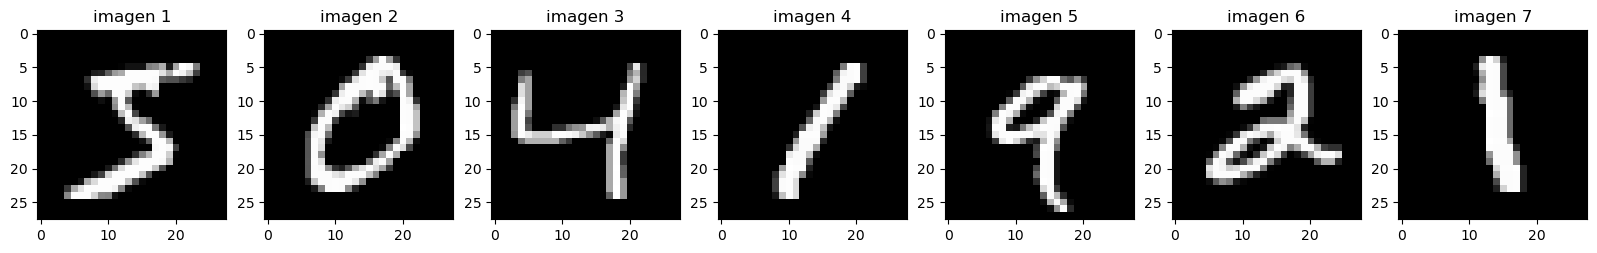

In [13]:
plt.figure(figsize=(20, 4))

for i, imag in enumerate(x_train[0: 7], start=1):
    plt.subplot(1, 7, i)
    plt.imshow(imag, cmap=plt.cm.gray)
    plt.title('imagen ' + str(i))

plt.show

## 2.- Preprocesamiento de datos

In [14]:
x_train.shape

(60000, 28, 28)

In [15]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


## 3.- Definicion de la arquitectura y busqueda de hiperparametros

#### A.- Definimos el espacio de busqueda para el hipertuning

In [16]:
from keras_tuner import Hyperband 

def model_builder(hp):
    model = keras.Sequential()

    model.add(keras.layers.Flatten(input_shape=(28, 28)))

     # espacio de capas y neuronas optimos
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(keras.layers.Dense(
        units=hp.Int('unit_' + str(i), min_value=32, max_value=160, step=32),
        activation='relu'
    ))

    # capa de salida
    model.add(keras.layers.Dense(10, activation='softmax'))

    # compilacion del modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


#### B.- Configuracion de la busqueda hyperband

In [17]:
from keras_tuner import Hyperband

# crear tuner
tuner = Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='dp_models',
    project_name='hyperband_tuning'
)

Reloading Tuner from dp_models/hyperband_tuning/tuner0.json


#### C.- Iniciamos el hyperband

In [ ]:
tuner.search(x_train, y_train,
             epochs=5,
             validation_data=(x_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"best hiden layers: {best_hps.get('num_layers')}")
print(f"best units: {best_hps.get('units_0')}")
print(f"best learning rate: {best_hps.get('learning_rate')}")
 


Search: Running Trial #76

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
64                |416               |unit_0
sigmoid           |sigmoid           |activacion
0.01              |0.001             |learning_rate
480               |224               |unit_1
448               |64                |unit_2
192               |32                |unit_3
192               |288               |unit_4
17                |17                |tuner/epochs
0                 |6                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/17
1875/1875 [==============================] - 24s 12ms/step - loss: 0.3880 - accuracy: 0.8947 - val_loss: 0.3321 - val_accuracy: 0.9037
Epoch 2/17
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2720 - accuracy: 0.9299 - val_loss: 0.3027 - val_accuracy: 0.9277
Epoch 3/17
1875/1875 [==================

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(x_train, y_train,
               epocs= 12,
               validation_data=(x_val, y_val),
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

## 3.- Evaluacion

In [ ]:
test_loos, test_acurracy = best_model.evaluate(x_test, y_test)
print(f'acurracy de los datos de prueba {test_acurracy}')

In [ ]:
history = best_model.history
# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva de precisión')
plt.show()